### iNNvestigate

iNNvestigate library provides tools for interpreting and explaining neural network predictions

In [1]:
!pip install innvestigate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 4.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.1 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 19.1 MB/s eta 0:00:00
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492024 sha256=1fb3d0bcc2afdc61ee7eae2f3f2dd72dff186eb8179797a6aed86a6c1a87f8d1
  Stored in directory: /root/.cache/pip/wheels/5e/a9/47/f118e66afd12240e4662752cc22cefae5d97275623aa8ef57d
Successfully built future
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successful

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import innvestigate
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import keras
from keras.layers import Activation

In [25]:
tf.compat.v1.disable_eager_execution()

## MNIST Dataset

Using the benchmark image dataset of handwritten digits for evaluating image classification models

In [26]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

11490434/11490434 [==============================] - 0s 0us/step


## Neural Network Model

In [27]:
# Neural Network Implentation
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [28]:
# Model Training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 20s 336us/sample - loss: 0.1727 - accuracy: 0.9485 - val_loss: 0.0539 - val_accuracy: 0.9821
Epoch 2/5
60000/60000 [==============================] - 19s 322us/sample - loss: 0.0487 - accuracy: 0.9852 - val_loss: 0.0401 - val_accuracy: 0.9865
Epoch 3/5
60000/60000 [==============================] - 20s 332us/sample - loss: 0.0345 - accuracy: 0.9890 - val_loss: 0.0353 - val_accuracy: 0.9891
Epoch 4/5
60000/60000 [==============================] - 20s 328us/sample - loss: 0.0271 - accuracy: 0.9916 - val_loss: 0.0463 - val_accuracy: 0.9853
Epoch 5/5
60000/60000 [==============================] - 19s 321us/sample - loss: 0.0224 - accuracy: 0.9923 - val_loss: 0.0272 - val_accuracy: 0.9913


In [29]:
# EEvaluation
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Test accuracy: 0.9912999868392944


In [30]:
def custom_relu(x):
    return keras.activations.relu(x, alpha=0.0, max_value=None, threshold=0.0)

In [31]:
model_without_softmax = Model(inputs=model.input, outputs=model.layers[-2].output)

for layer in model_without_softmax.layers:
    if isinstance(layer, keras.layers.ReLU):
        layer.activation = custom_relu

## Analyzers

We employ three different analyzers from iNNvestigate to interpret model predictions.

In [32]:
# 3 Analyzers
analyzers = {
    "Gradient": innvestigate.create_analyzer("gradient", model_without_softmax),
    "Deep Taylor": innvestigate.create_analyzer("deep_taylor", model_without_softmax),
    "Input_T_Gradient": innvestigate.create_analyzer("input_t_gradient", model_without_softmax)
}

In [33]:
analysis_results = {name: analyzer.analyze(x_test) for name, analyzer in analyzers.items()}

### Gradient analyzer: Computes gradients of output with respect to input to measure prediction sensitivity.

Gradient Analyzer:


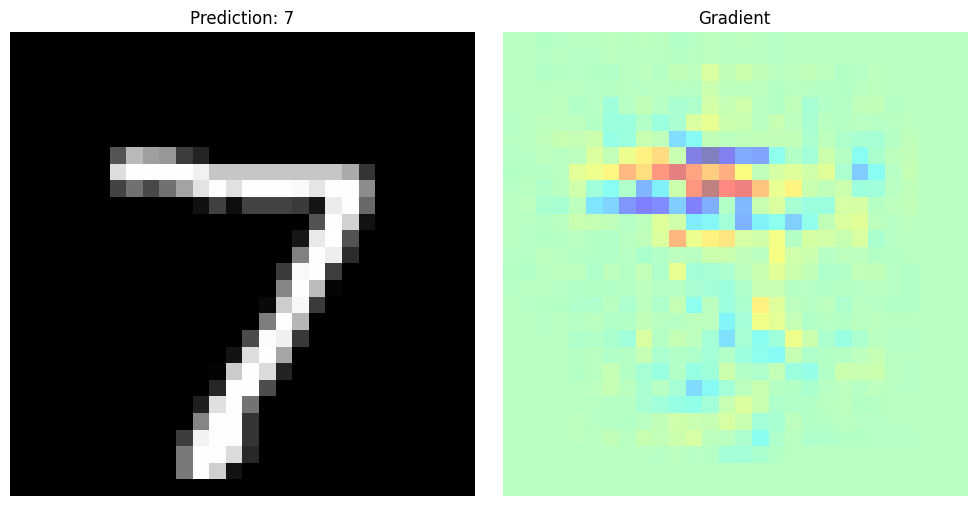

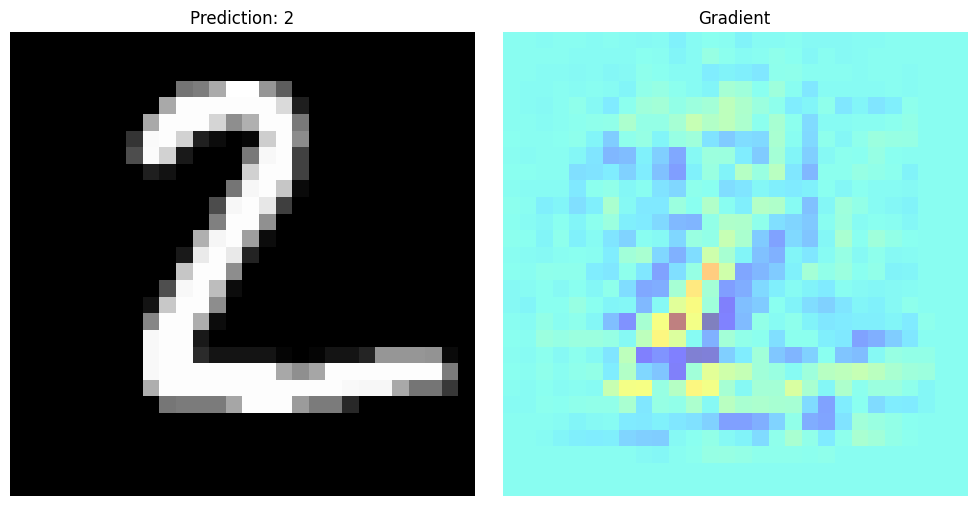

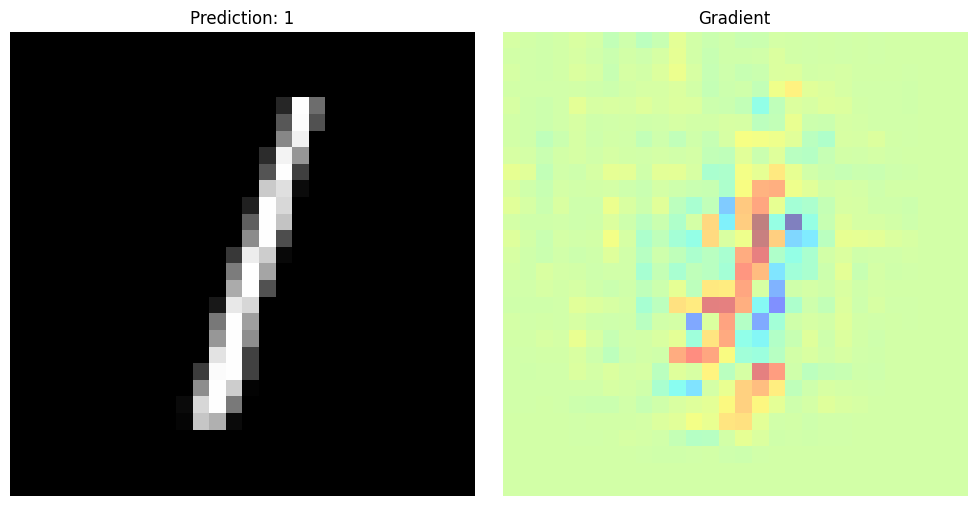

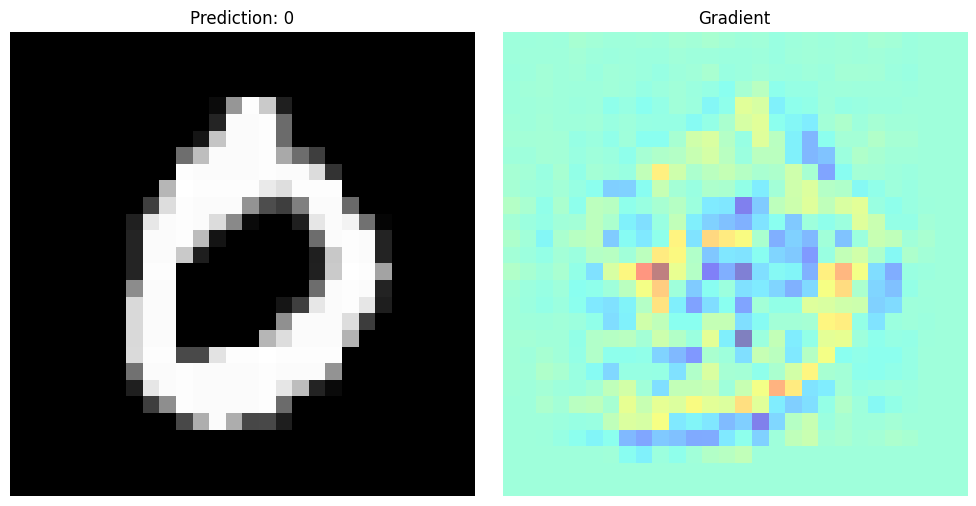

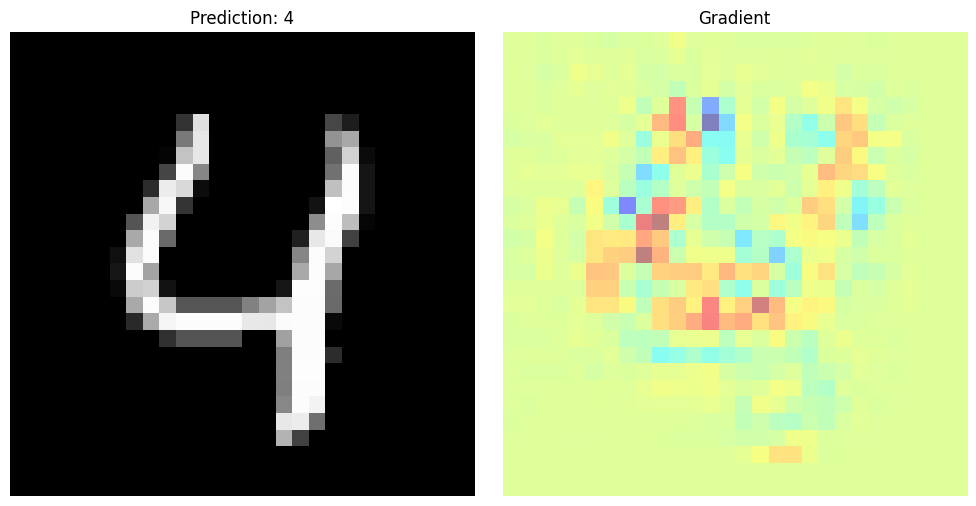

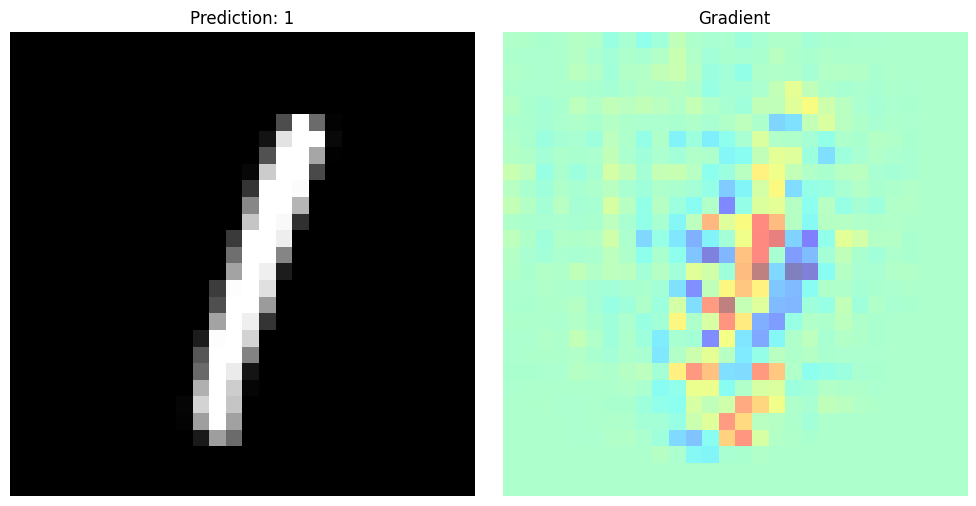

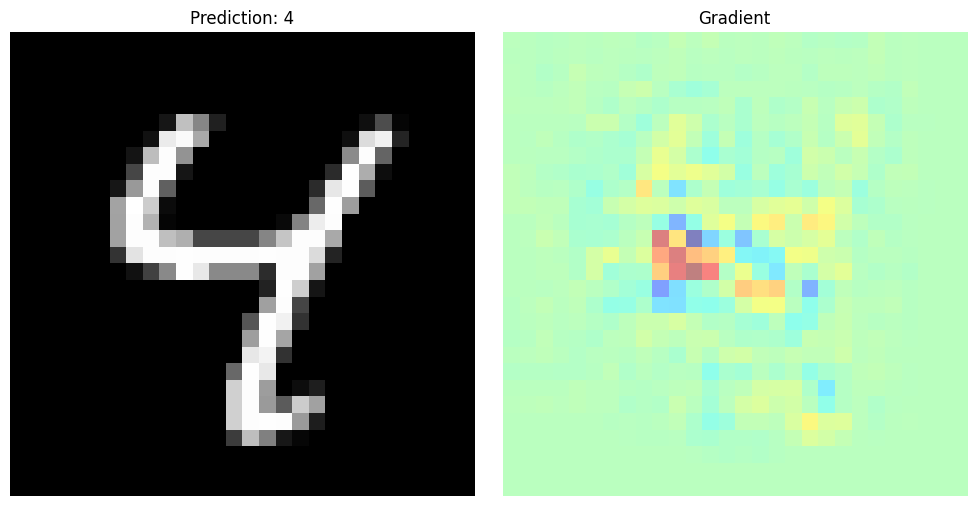

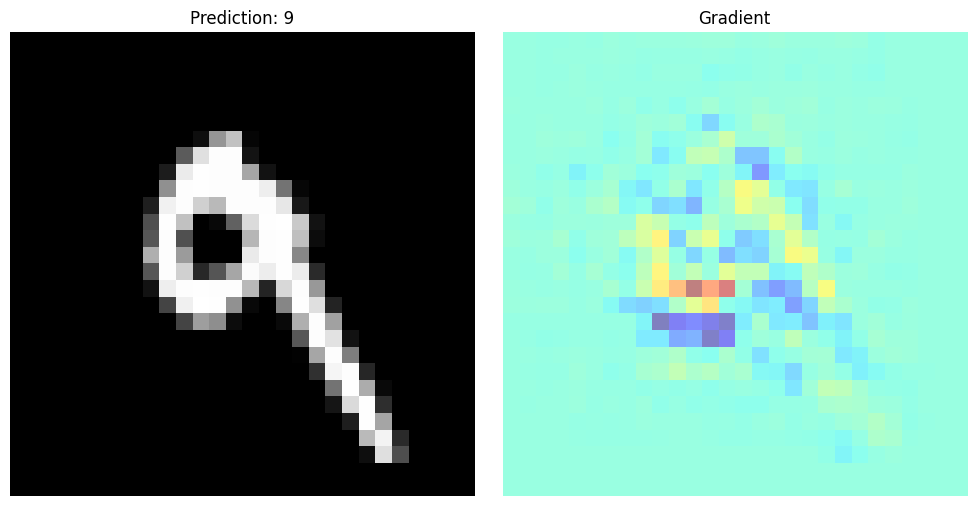

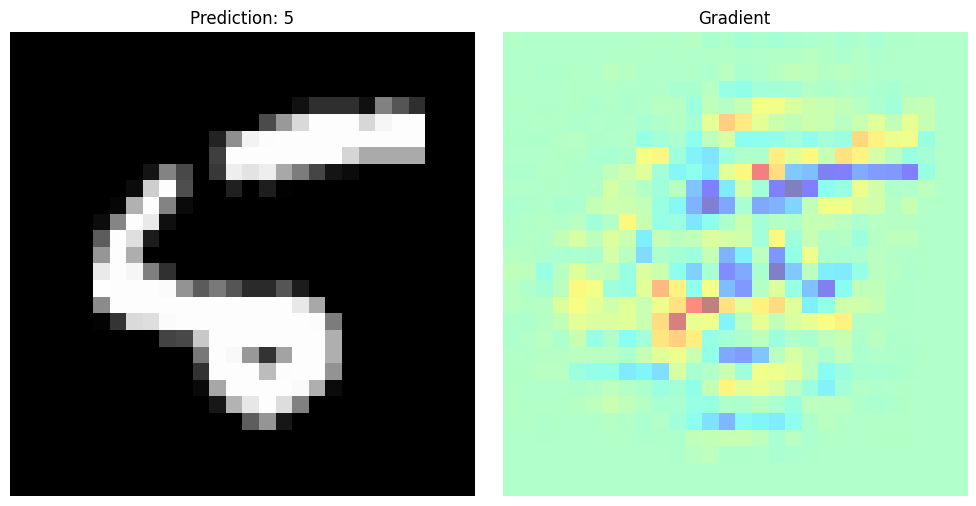

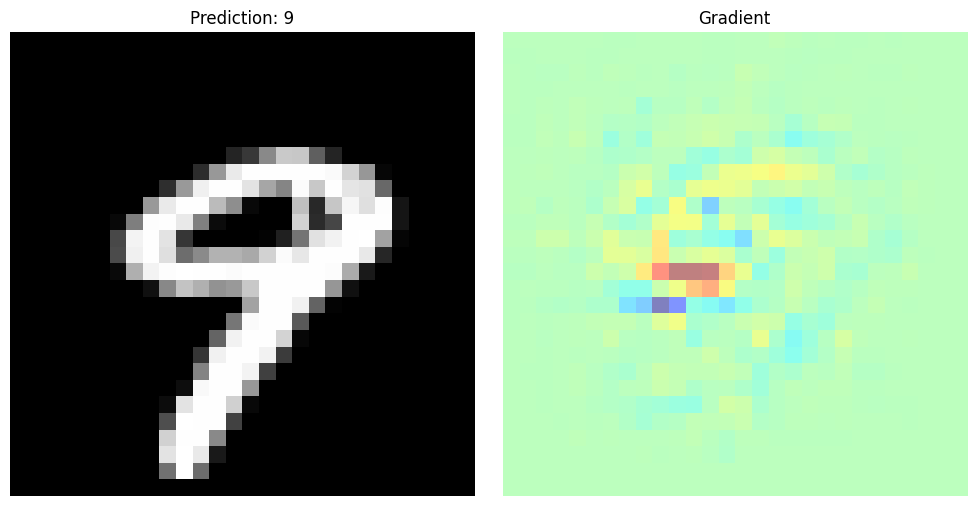

In [37]:
# Gradient Analysis Report
print("Gradient Analyzer:")
for i in range(10):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Prediction: {}".format(np.argmax(model.predict(np.expand_dims(x_test[i], axis=0)))))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(analysis_results["Gradient"][i].squeeze(), cmap='jet', alpha=0.5)
    plt.title("Gradient")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### Deep Taylor analyzer: Utilizes Taylor decomposition to compute relevance scores for input features.

Deep Taylor Analyzer:


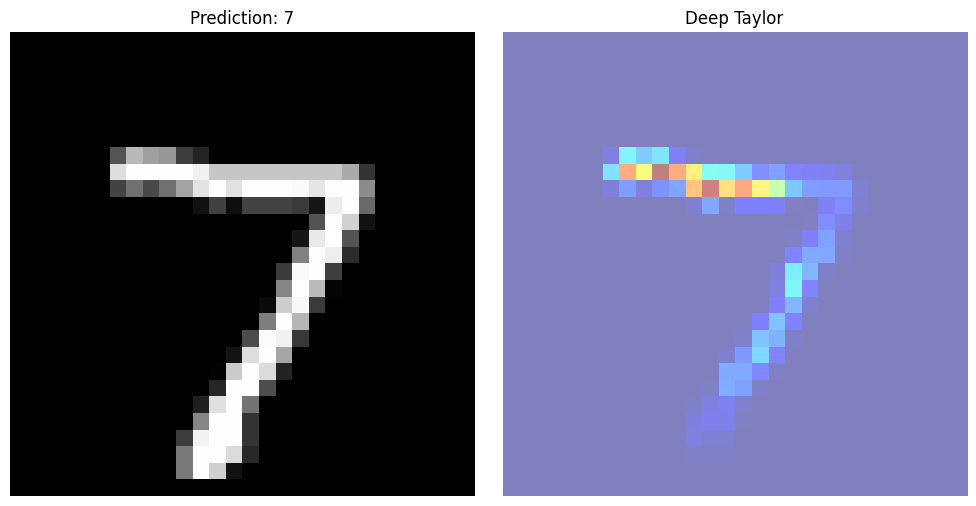

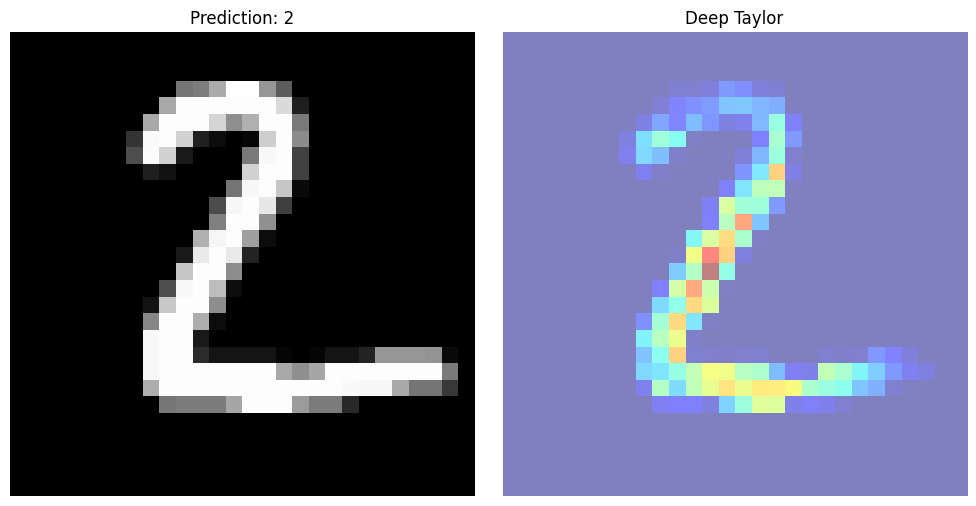

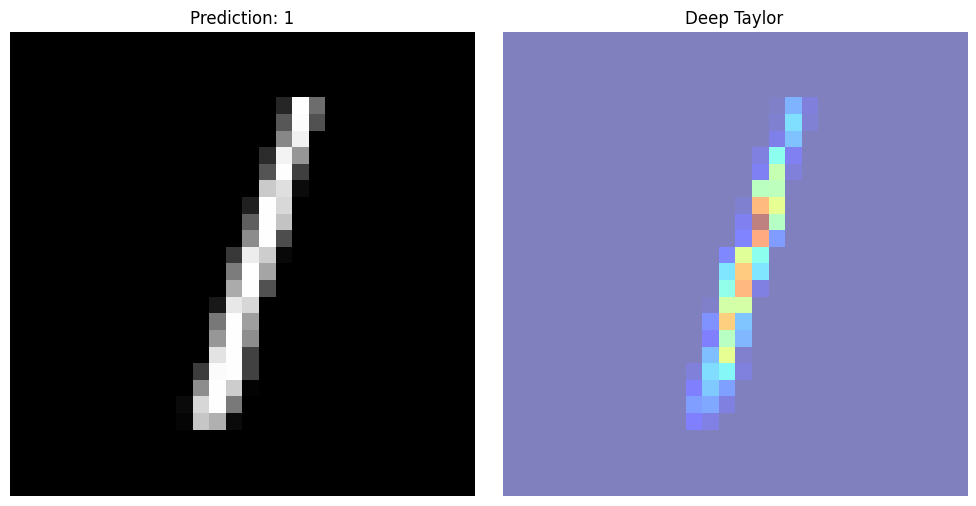

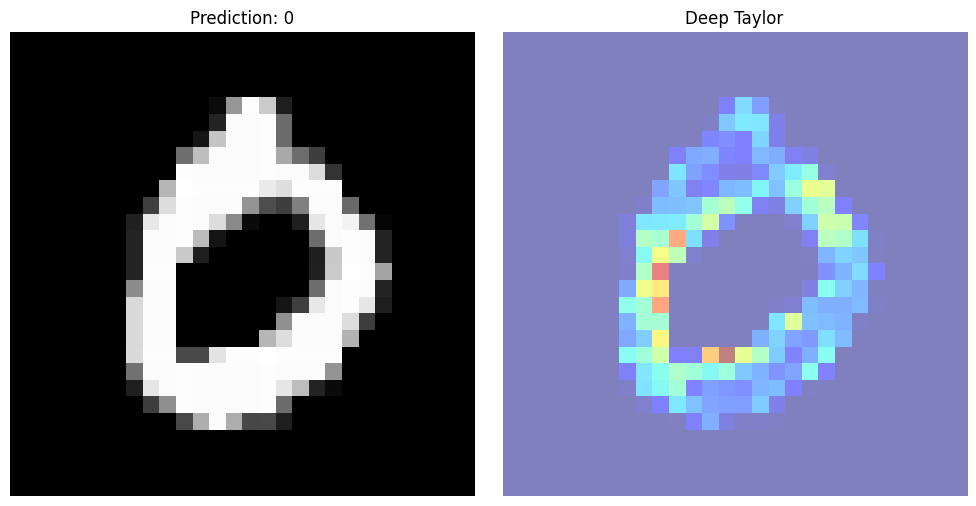

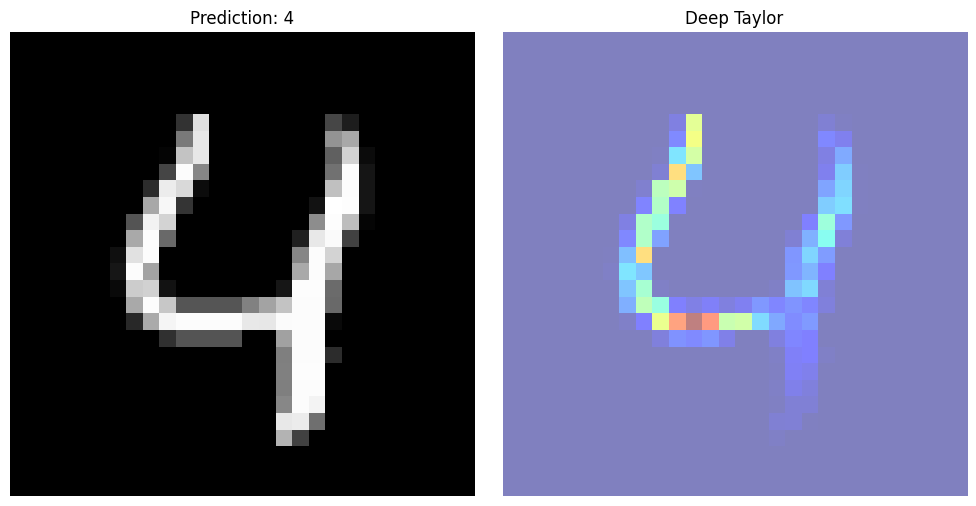

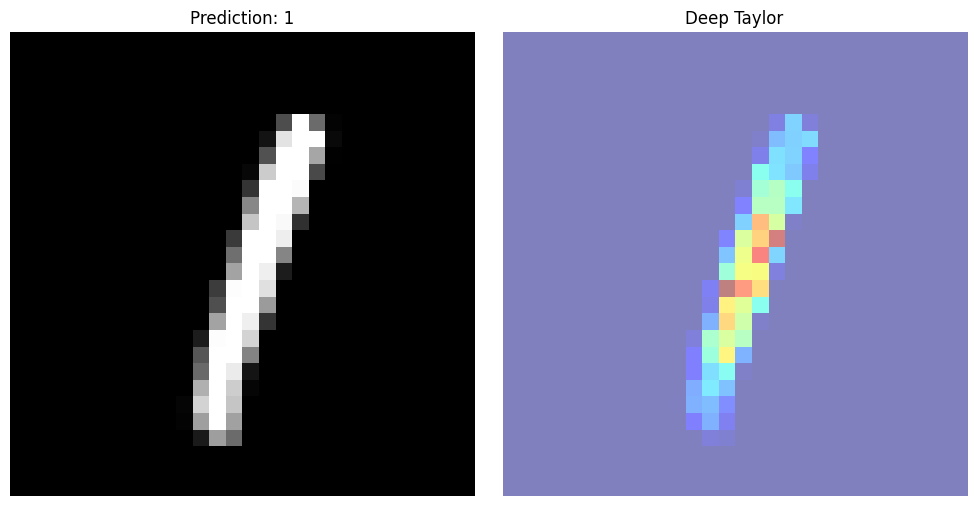

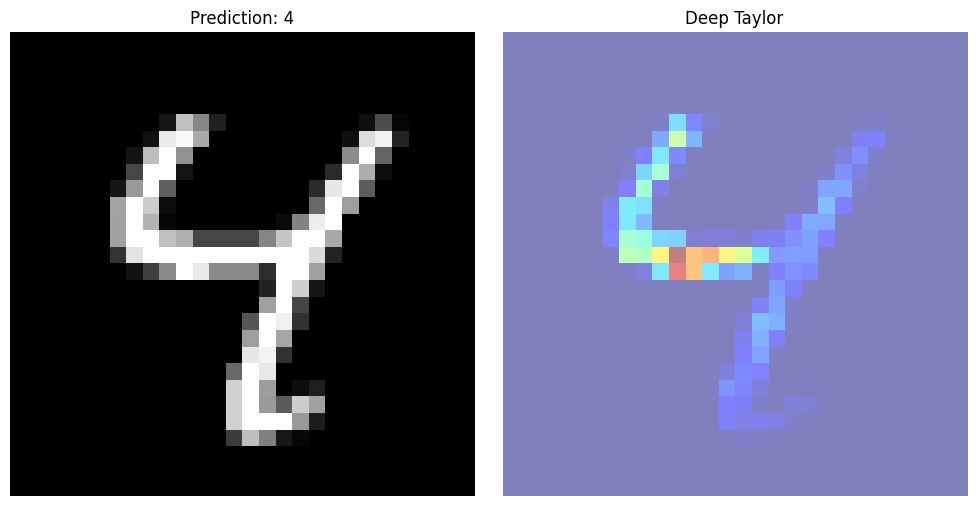

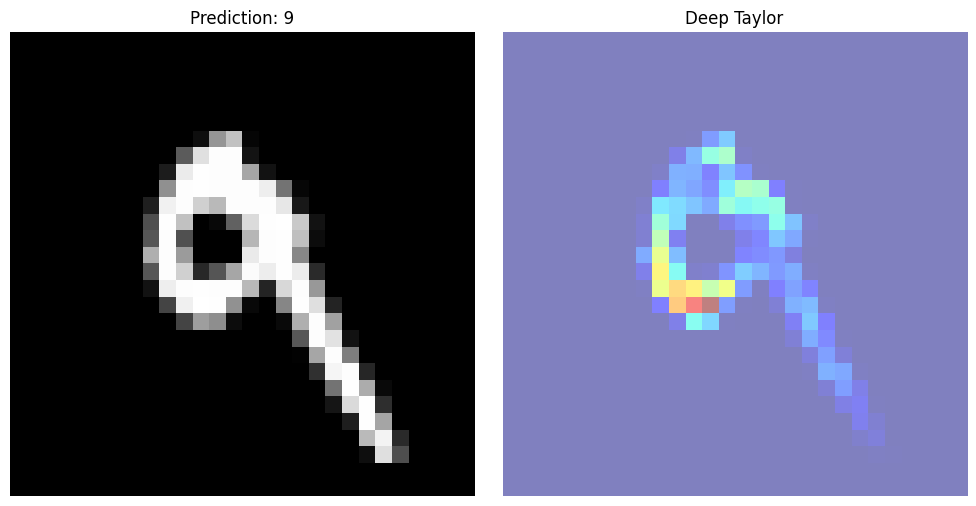

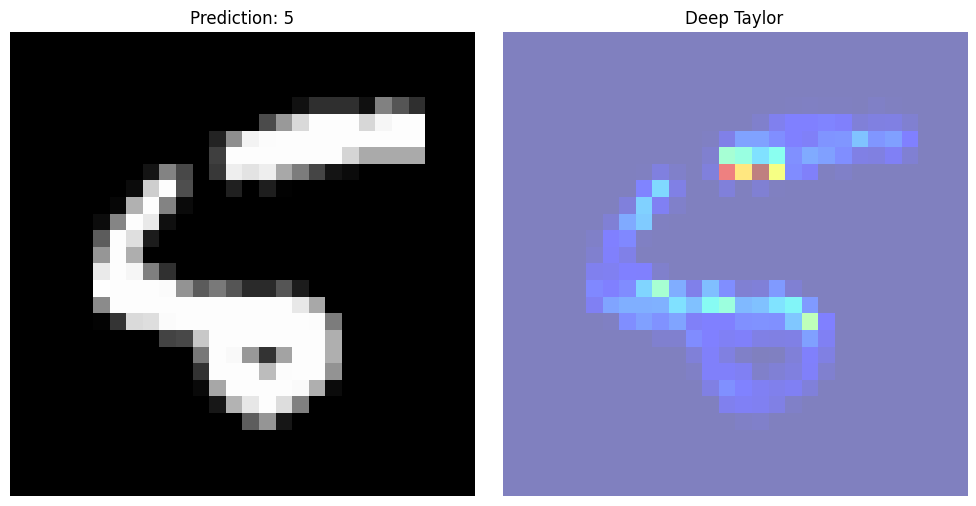

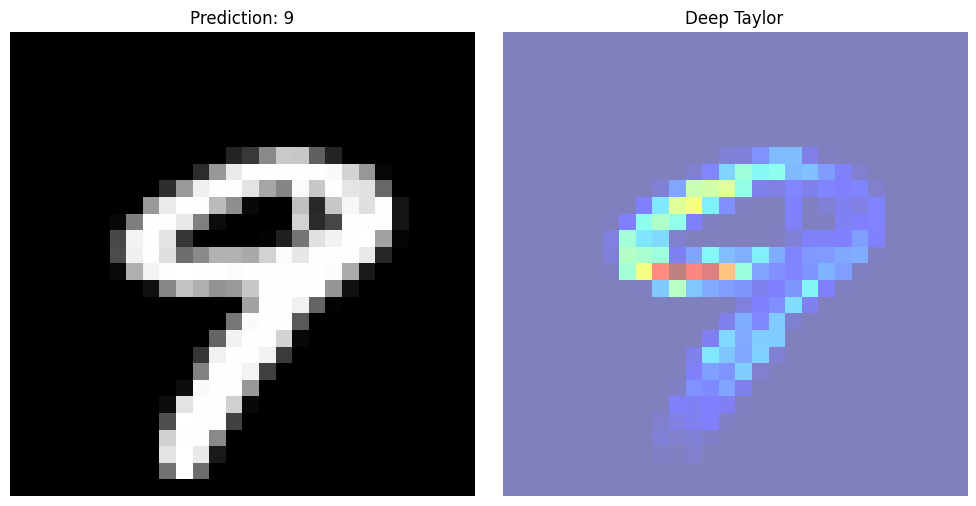

In [35]:
# Analysis Report of Deep Taylor analyzer
print("Deep Taylor Analyzer:")
for i in range(10):
    plt.figure(figsize=(5, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Prediction: {}".format(np.argmax(model.predict(np.expand_dims(x_test[i], axis=0)))))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(analysis_results["Deep Taylor"][i].squeeze(), cmap='jet', alpha=0.5)
    plt.title("Deep Taylor")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### Input_T_Gradient analyzer: A gradient-based method incorporating input values in the computations.

Input_T_Gradient Analyzer:


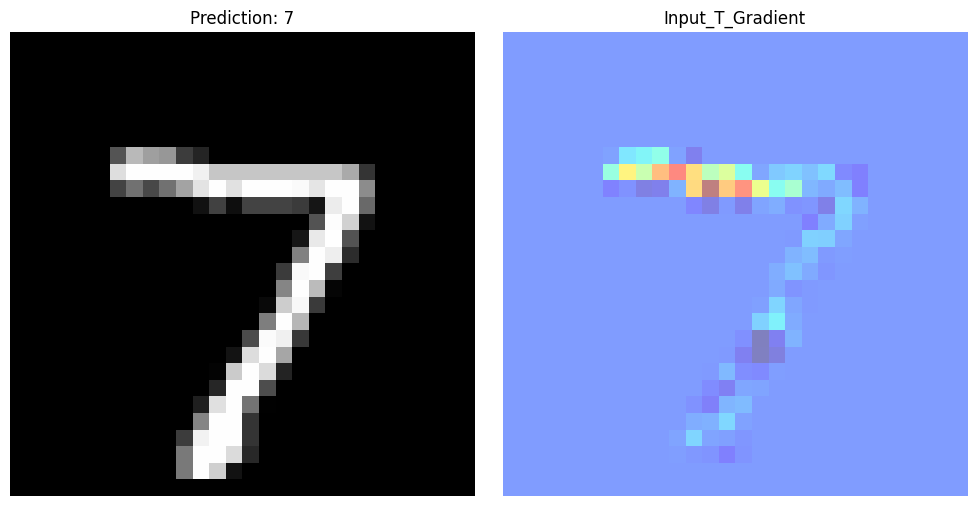

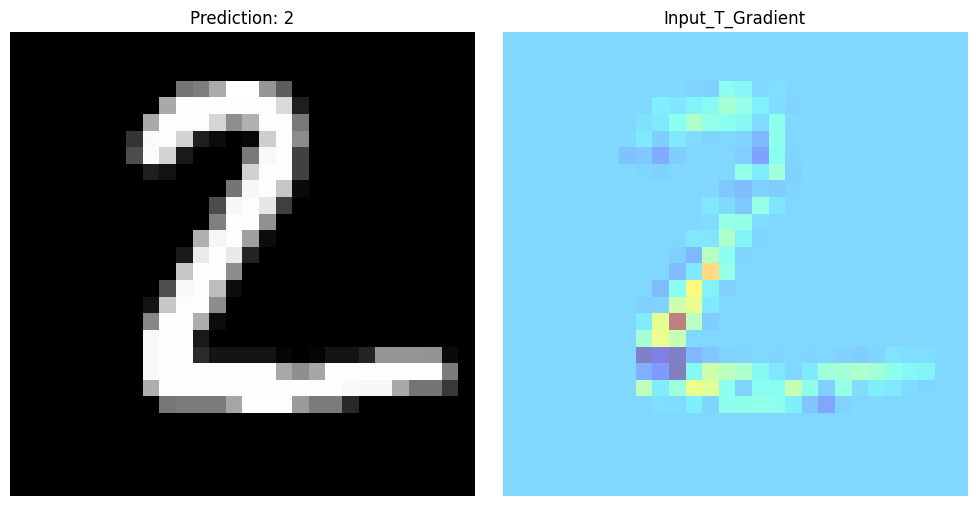

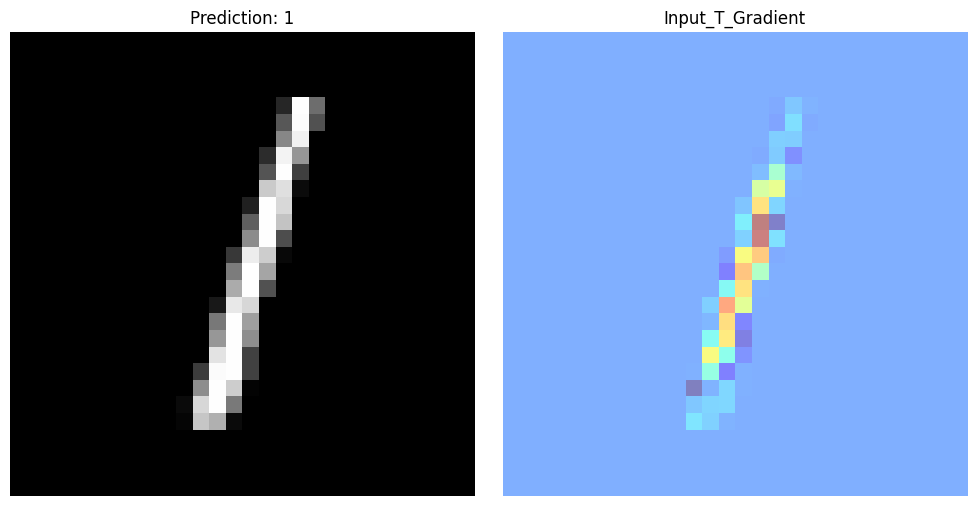

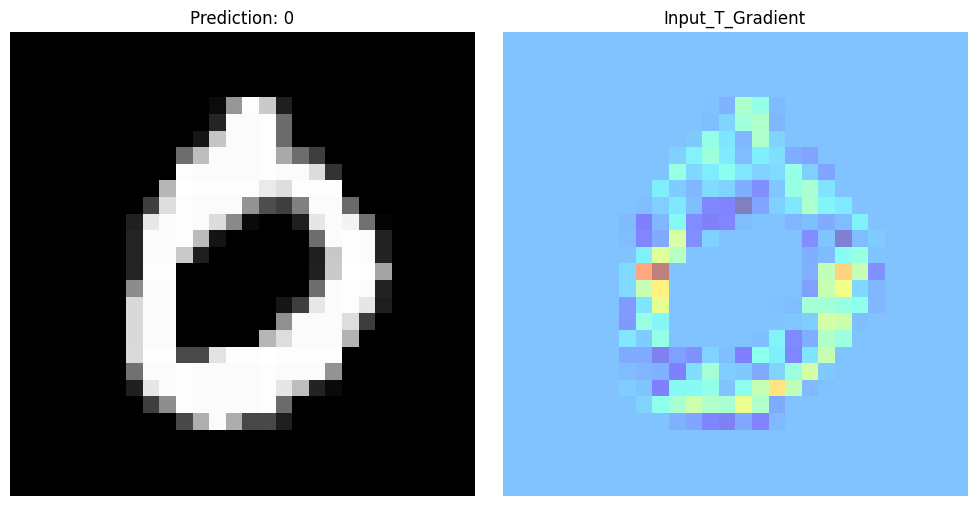

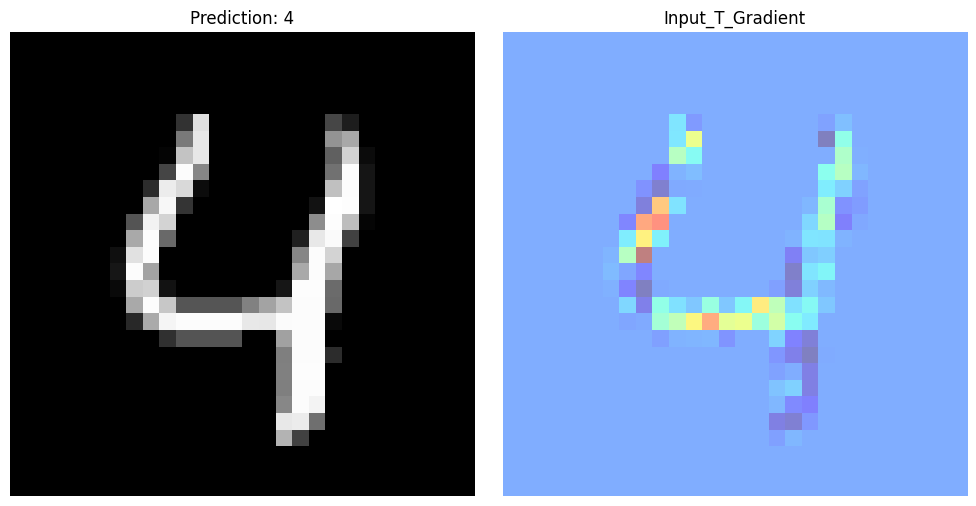

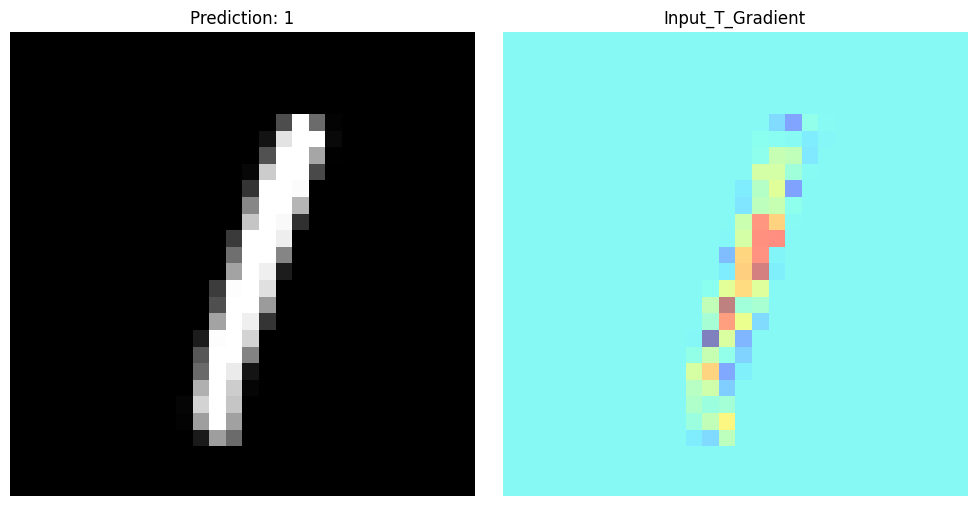

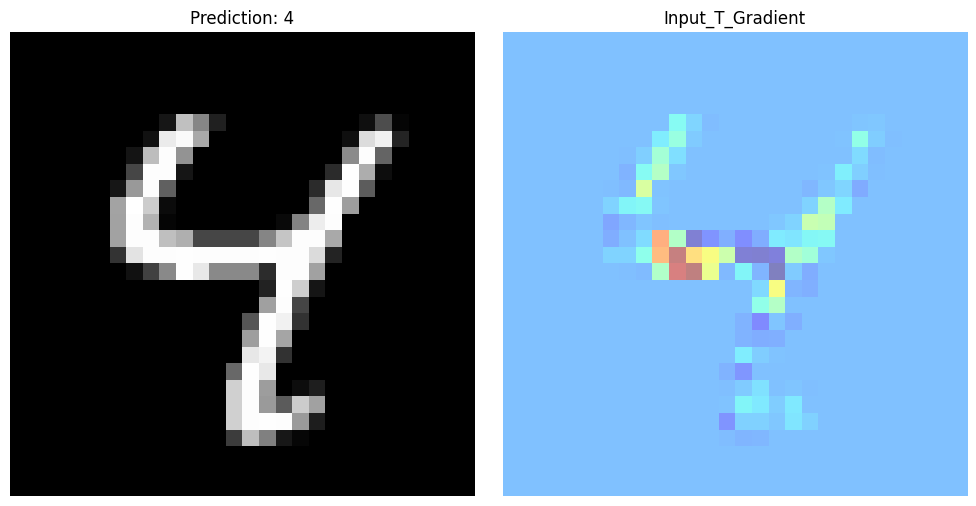

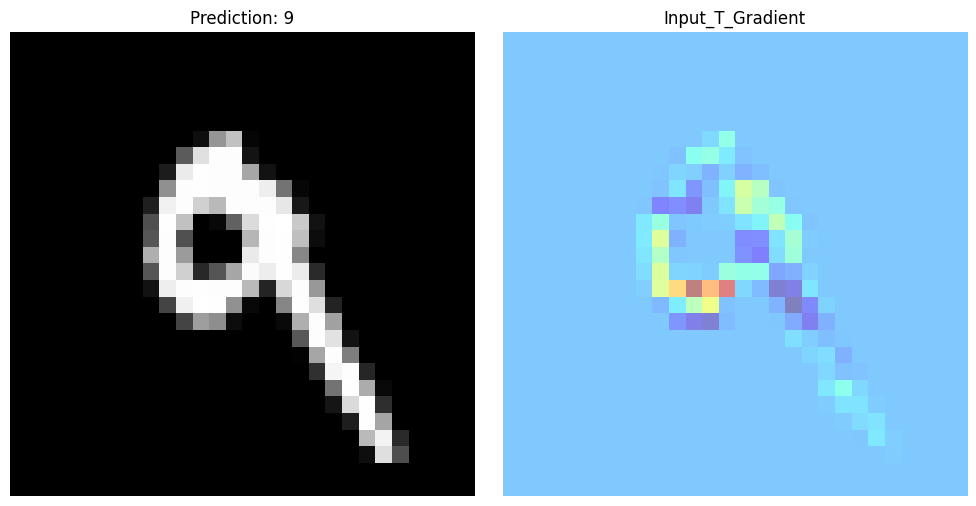

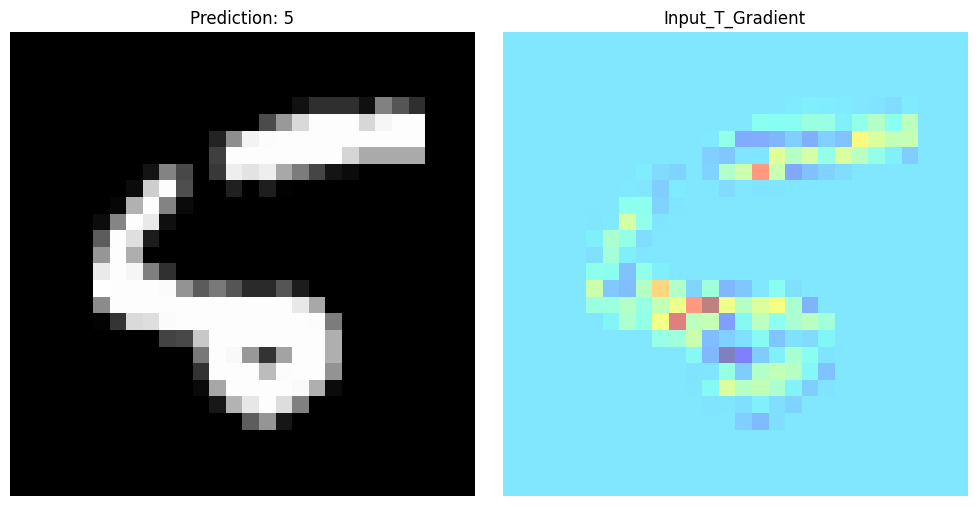

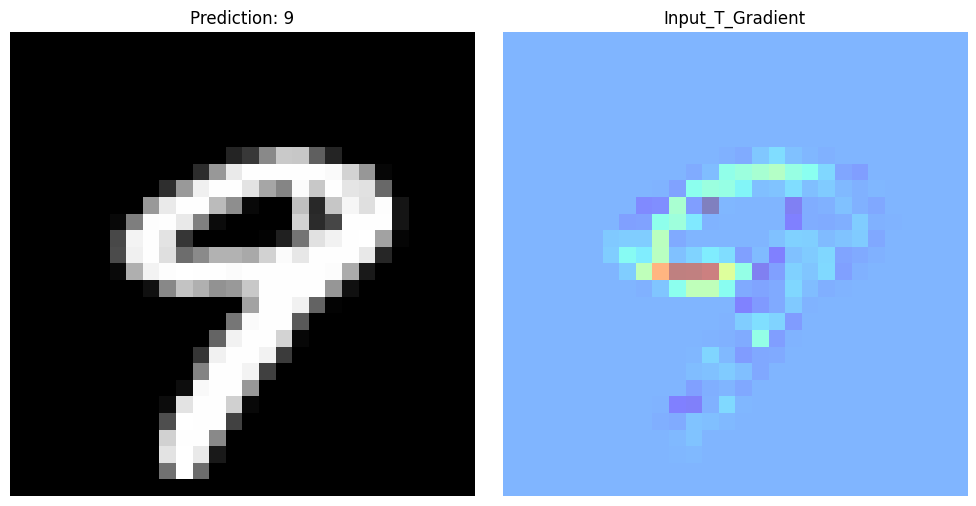

In [36]:
# Analysis Report of Input_T_Gradient analyzer
print("Input_T_Gradient Analyzer:")
for i in range(10):
    plt.figure(figsize=(5, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Prediction: {}".format(np.argmax(model.predict(np.expand_dims(x_test[i], axis=0)))))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(analysis_results["Input_T_Gradient"][i].squeeze(), cmap='jet', alpha=0.5)
    plt.title("Input_T_Gradient")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

### Comparative analysis of analyzers: Visualized and compared results from multiple analyzers for interpretability insights.

Analysis Comparison:


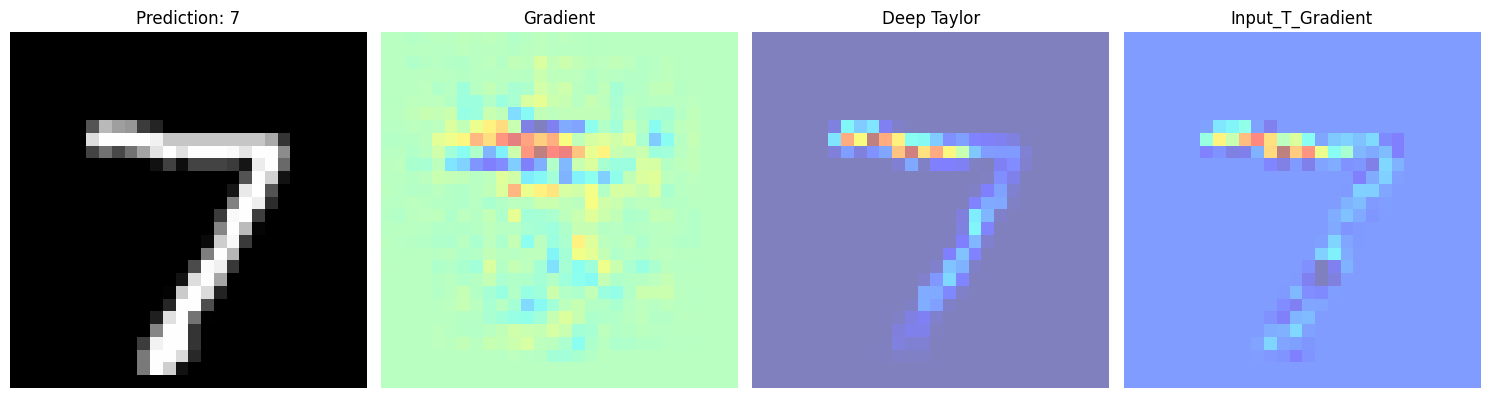

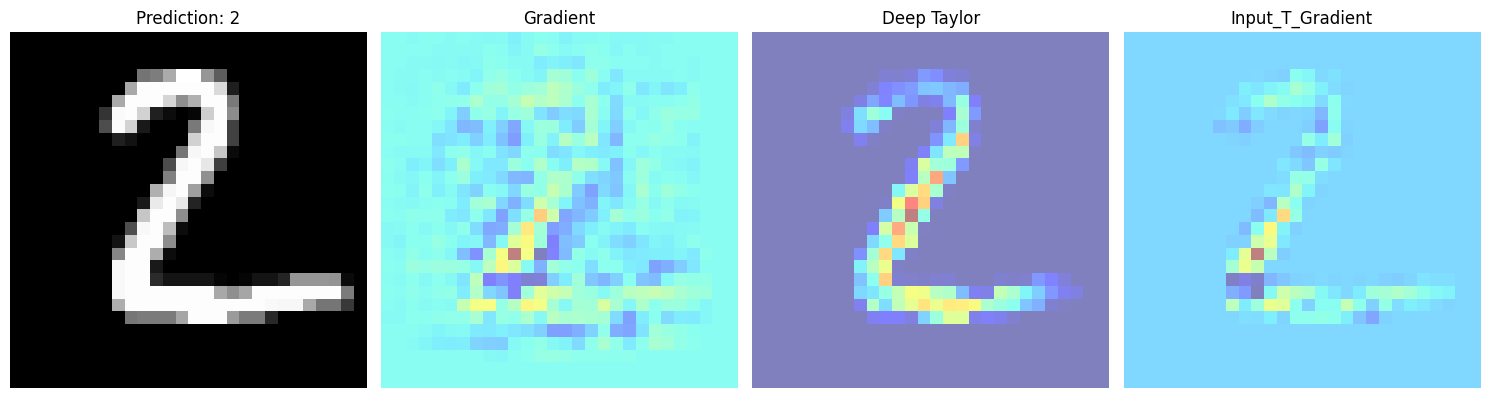

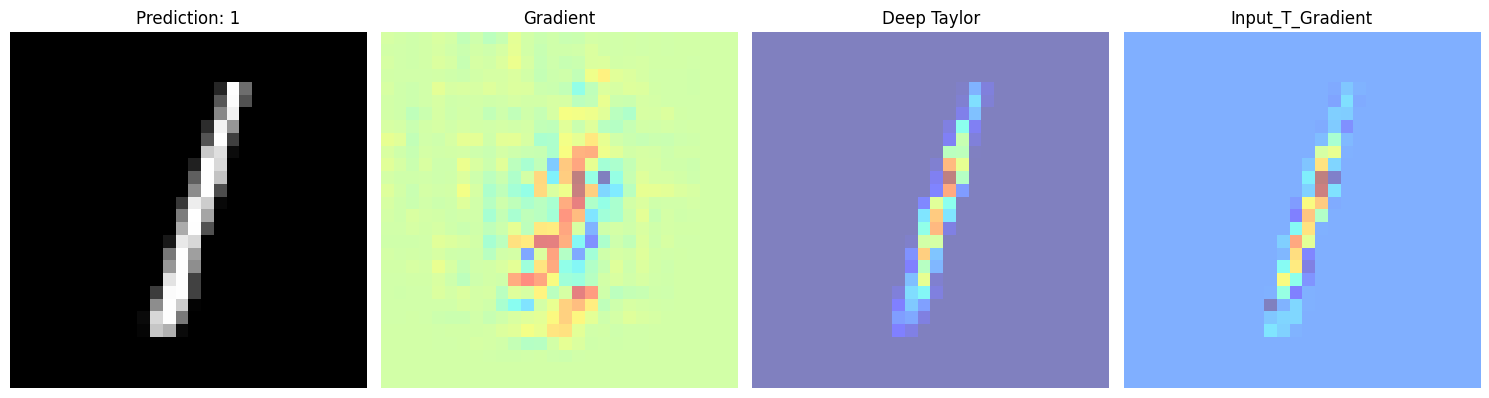

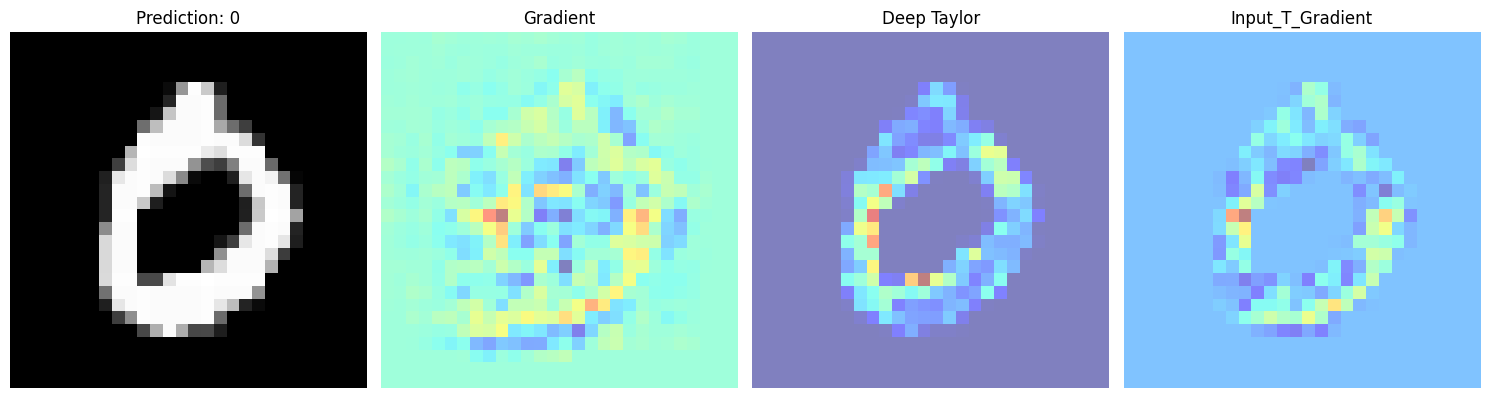

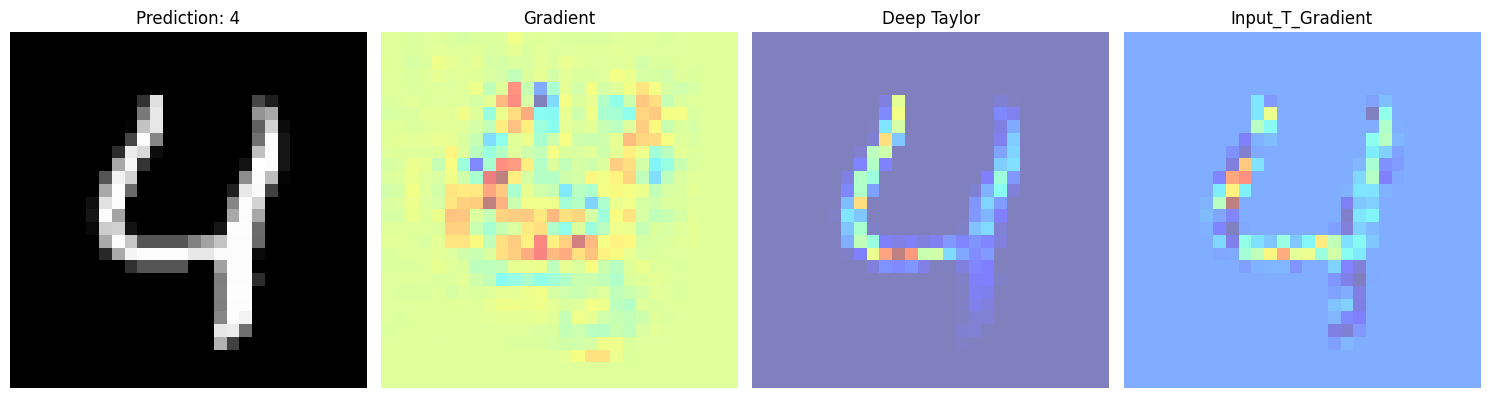

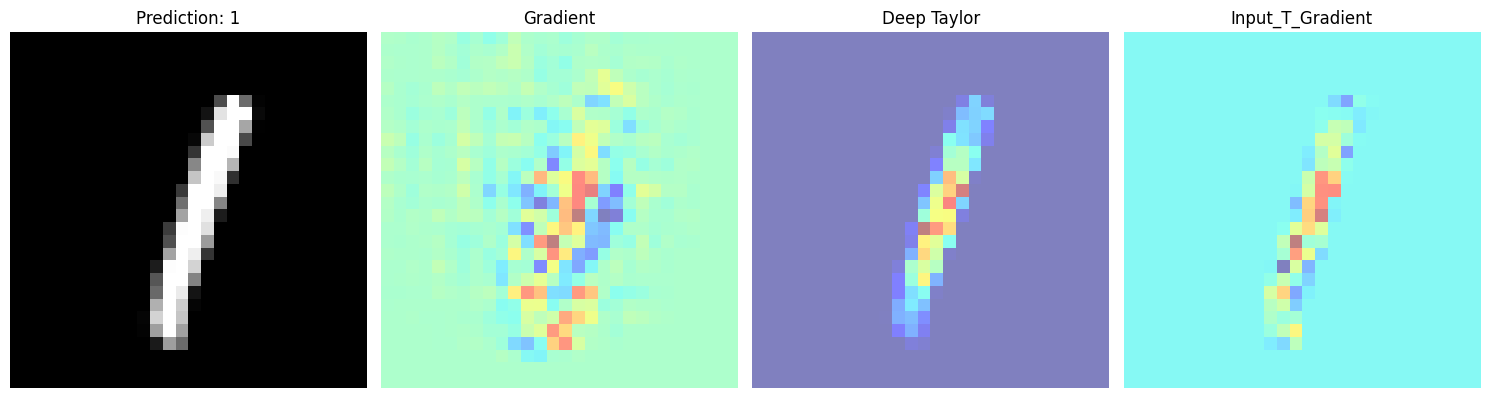

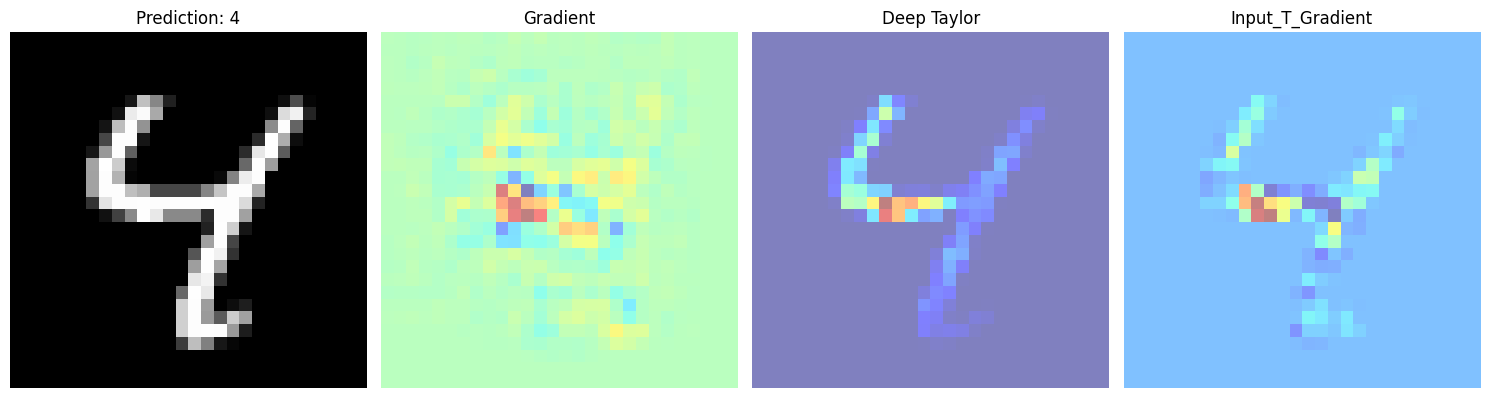

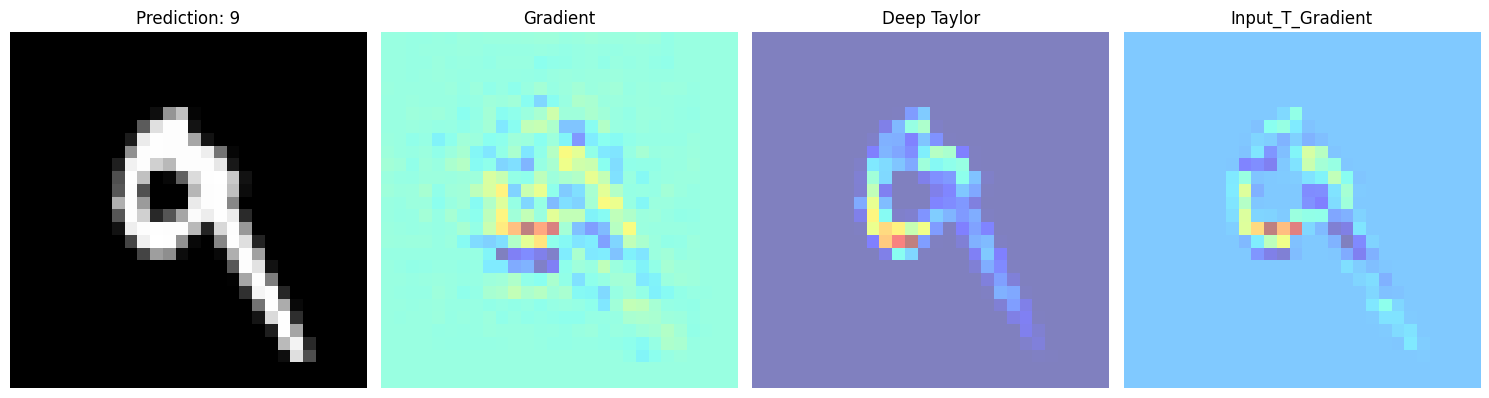

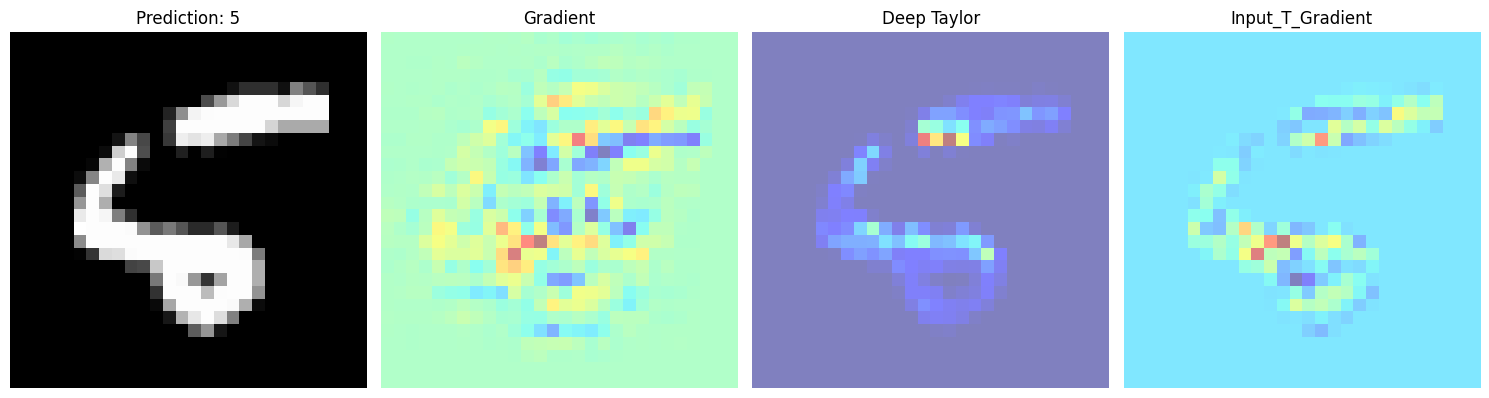

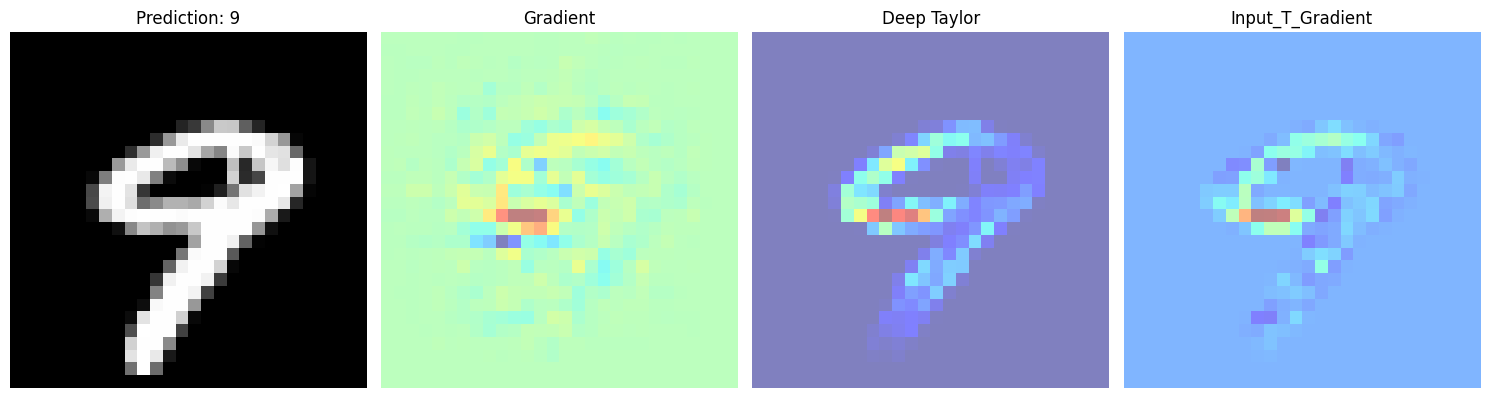

In [39]:
# Comparitive Analysis
print("Analysis Comparison:")
for i in range(10):
    plt.figure(figsize=(15, 5))
    
    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Prediction: {}".format(np.argmax(model.predict(np.expand_dims(x_test[i], axis=0)))))
    plt.axis('off')
    
    # Gradient Analyzer
    plt.subplot(1, 4, 2)
    plt.imshow(analysis_results["Gradient"][i].squeeze(), cmap='jet', alpha=0.5)
    plt.title("Gradient")
    plt.axis('off')
    
    # Deep Taylor Analyzer
    plt.subplot(1, 4, 3)
    plt.imshow(analysis_results["Deep Taylor"][i].squeeze(), cmap='jet', alpha=0.5)
    plt.title("Deep Taylor")
    plt.axis('off')
    
    # Input_T_Gradient Analyzer
    plt.subplot(1, 4, 4)
    plt.imshow(analysis_results["Input_T_Gradient"][i].squeeze(), cmap='jet', alpha=0.5)
    plt.title("Input_T_Gradient")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

We demonstrated the application of convolutional neural networks for image classification tasks on the MNIST and Fashion MNIST datasets, while leveraging the iNNvestigate library and its diverse analyzers to interpret and explain the models' predictions, thereby gaining valuable insights into their decision-making processes.